In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

In [3]:
ml_client = MLClient(DefaultAzureCredential(),
                    subscription_id= "59370939-111d-4222-9d04-935c1efb51d7",
                    resource_group_name= "santosh24496-rg",
                    workspace_name= "ML_Practice")

In [4]:
data_asset = ml_client.data.list()
for da in data_asset:
    print(da.name)

yt_shorts
food_demand_forecast
apple_stock_price


In [5]:
data_asset = ml_client.data.get(name='apple_stock_price', version = '1')
print(data_asset.path)

azureml://subscriptions/59370939-111d-4222-9d04-935c1efb51d7/resourcegroups/santosh24496-rg/workspaces/ML_Practice/datastores/workspaceblobstore/paths/UI/2025-12-02_093119_UTC/P614 DATASET.csv


In [6]:
dataset = pd.read_csv(data_asset.path)
dataset.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
5,2012-01-10,60.844284,60.857143,60.214287,60.462856,52.248333,64549100
6,2012-01-11,60.382858,60.407143,59.901428,60.364285,52.163139,53771200
7,2012-01-12,60.325714,60.414288,59.821430,60.198570,52.019955,53146800
8,2012-01-13,59.957142,60.064285,59.808571,59.972858,51.824898,56505400
9,2012-01-17,60.599998,60.855713,60.422855,60.671429,52.428562,60724300


In [7]:
def create_features(data):
    data['Date'] = pd.to_datetime(data['Date'])
    d = data.set_index('Date').sort_index()
    d = d['Close'].asfreq('B')
    d = d.ffill()
    pct = d.pct_change()
    features = pd.DataFrame({
        'r_1' : pct.shift(1),
        'r_5' : pct.rolling(5).mean().shift(1),
        'std' : pct.rolling(10).std().shift(1),
        'mavg_5' : d.rolling(5).mean().shift(1),
        'mavg_20' : d.rolling(20).mean().shift(1),
        'rsi_14' : (pct.clip(lower = 0).rolling(14).mean()/
                    (pct.abs().rolling(14).mean() + 1e-9)).shift(1),
        'dow' : d.index.dayofweek
    }).dropna()
    y = pct.loc[features.index]
    return features, y, d

In [8]:
X, y, price = create_features(dataset)

In [9]:
#%pip install keras_tuner

In [10]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

2025-12-07 11:40:30.592604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
scaler = MinMaxScaler()
X_scaled= scaler.fit_transform(X)

In [12]:
#h = 30
#X_train, X_test = X_scaled[:-h], X_scaled[-h:]
#y_train, y_test = y.iloc[:-h], y.iloc[-h:]
#X_train.shape, X_test.shape,y_train.shape, y_test.shape

In [17]:
# Reshape for GRU (samples, timesteps, features)
X_gru = X_scaled.reshape((X_scaled.shape[0],1,X_scaled.shape[1]))

In [18]:
#Splitting the data again for the GRU
h = 30
X_train , X_test = X_gru[:-h], X_gru[-h:]
y_train , y_test = y.iloc[:-h], y.iloc[-h:]

In [19]:
X_train.shape

(2035, 1, 7)

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# GRU Model

## Define Model Builder Function

In [40]:
def build_model_stage1(hp):
    
    model = Sequential()

    model.add(GRU(
        units = hp.Int('gru_units', min_value = 16, max_value = 64, step = 16),
        input_shape = (X_train.shape[1], X_train.shape[2]),
        activation = 'tanh',
        kernel_initializer= 'glorot_uniform',
        return_sequences= True
    ))

    model.add(GRU(
        units = hp.Int('gru_units', min_value = 16, max_value = 64, step= 16),
        activation = 'tanh',
        kernel_initializer= 'glorot_uniform',
        return_sequences= False
    ))

    model.add(Dropout(hp.Float('dropout', min_value = 0.1, max_value = 0.4, step = 0.1)))

    model.add(Dense(1, activation = 'linear'))

    model.compile(optimizer = Adam(), loss = 'mse', metrics = ['mae'])
    return model

## Run Tuner (Stage 1)

In [41]:
tuner1 = kt.RandomSearch(
    build_model_stage1, objective= 'val_loss', max_trials = 6,
    executions_per_trial = 1, directory = 'stage1_tuning', project_name = 'gru_stage1'
)

tuner1.search(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))
best_model_stage1 = tuner1.get_best_models(num_models=1)[0]

Trial 6 Complete [00h 00m 28s]
val_loss: 0.00010129839211003855

Best val_loss So Far: 0.00010129839211003855
Total elapsed time: 00h 02m 53s


## Stage 2 Tuning (Learning Rate + Optimizer)

In [70]:
def build_model_stage2(hp):
    model = Sequential()

    model.add(GRU(
        units = best_model_stage1.layers[0].units,
        input_shape = (X_train.shape[1], X_train.shape[2]),
        activation='tanh',
        kernel_initializer= 'glorot_uniform',
        return_sequences= True
    ))

    model.add(GRU(
        units = best_model_stage1.layers[1].units,
        activation='tanh',
        kernel_initializer= 'glorot_uniform',
        return_sequences= False
    ))

    model.add(Dropout(best_model_stage1.layers[2].rate))

    model.add(Dense(1, activation= 'linear'))

    lr = hp.Choice('learning_rate', values=[0.1,0.001,0.0001, 0.00001])
    opt = hp.Choice('optimizer', values = ['adam', 'rmsprop'])

    if opt == 'adam':
        optimizer = Adam(learning_rate= lr)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate= lr)

    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
    return model
 

In [71]:
tuner2 = kt.RandomSearch(
    build_model_stage2, objective='val_loss', max_trials=6,
    executions_per_trial = 1, directory = 'stage2_tuning', project_name ='gru_stage2'
)

tuner2.search(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))
best_model_stage2 = tuner2.get_best_models(num_models=1)[0]

Trial 6 Complete [00h 00m 27s]
val_loss: 0.0004346968198660761

Best val_loss So Far: 0.00010169313463848084
Total elapsed time: 00h 02m 49s


In [88]:
tuner2.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')

0.001

In [106]:
tuner2.get_best_hyperparameters(num_trials=1)[0].get('optimizer')

'adam'

## Stage 3 tuning Activation & Kernel Initializer

In [96]:
best_model_stage2.optimizer.name

'adam'

In [89]:
best_model_stage2.optimizer.learning_rate.numpy()

np.float32(0.001)

In [107]:
def build_model_stage3(hp):
    model = Sequential()

    model.add(GRU(
        units = best_model_stage1.layers[0].units,
        input_shape = (X_train.shape[1], X_train.shape[2]),
        activation= hp.Choice('activation', values =['tanh', 'relu']),
        kernel_initializer= hp.Choice('initializer', values =['glorot_uniform','he_normal']),
        return_sequences= True
    ))

    model.add(GRU(
        units = best_model_stage1.layers[1].units,
        activation= hp.Choice('activation', values =['tanh', 'relu']),
        kernel_initializer= hp.Choice('initializer', values =['glorot_uniform','he_normal']),
        return_sequences= False
    ))

    model.add(Dropout(best_model_stage1.layers[2].rate))

    model.add(Dense(1, activation= 'linear'))

    learning_rate_num = tuner2.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')
    optimizer_name = best_model_stage2.optimizer.name

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate = learning_rate_num)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.Keras.optimizer.RMSprop(learning_rate = learning_rate_num)

    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
    return model
 

In [108]:
tuner3 = kt.RandomSearch(
    build_model_stage3, objective = 'val_loss', max_trials= 4,
    executions_per_trial = 1, directory = 'stage3_tuning', project_name = 'gru_stage3'
)

tuner3.search(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))
best_model_stage3 = tuner3.get_best_models(num_models=1)[0]

Trial 4 Complete [00h 00m 29s]
val_loss: 0.00010221211414318532

Best val_loss So Far: 0.00010221211414318532
Total elapsed time: 00h 01m 58s


In [115]:
tuner3.get_best_hyperparameters(num_trials=1)[0].get('initializer')

'glorot_uniform'

In [111]:
best_gru = best_model_stage3

In [121]:
best_gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 48)          │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 48)             │        14,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,369 (87.38 KB)

 Trainable params: 22,369 (87.38 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
best_gru.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 1, 7),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'GRU',
   'config': {'name': 'gru',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'zero_output_for_mask': False,
    'units': 48,
    'activation': 'relu',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform'

# Final Model

In [146]:
best_params = tuner3.get_best_hyperparameters(num_trials=1)[0]

In [156]:
best_gru.layers[0].kernel_initializer.__class__.__name__

'GlorotUniform'

In [160]:
print("Best tuned Hyperparameters\n")
print(f"layer 1 units : {best_gru.layers[0].units}")
print(f"layer 2 units : {best_gru.layers[1].units}")
print(f"dropout percent : {best_gru.layers[2].rate}")
print(f"optimzer : {best_gru.optimizer.name}")
print(f"learning rate : {best_gru.optimizer.learning_rate.numpy()}")
print(f"layer 1 activation : {best_gru.layers[0].activation.__name__}")
print(f"layer 1 initializer : {best_gru.layers[0].kernel_initializer.__class__.__name__}")
print(f"layer 2 activation : {best_gru.layers[1].activation.__name__}")
print(f"layer 2 initializer : {best_gru.layers[1].kernel_initializer.__class__.__name__}")

Best tuned Hyperparameters

layer 1 units : 48
layer 2 units : 48
dropout percent : 0.30000000000000004
optimzer : adam
learning rate : 0.0010000000474974513
layer 1 activation : relu
layer 1 initializer : GlorotUniform
layer 2 activation : relu
layer 2 initializer : GlorotUniform


In [111]:
def final_model ():
    
    model = Sequential()

    model.add(GRU(
        units =48,
        input_shape = (X_train.shape[1], X_train.shape[2]),
        activation = 'relu',
        kernel_initializer= 'glorot_uniform',
        return_sequences= False
    ))


    model.add(Dropout(0.1))

    model.add(Dense(1, activation = 'linear'))

    model.compile(optimizer = Adam(learning_rate= 0.001), loss = 'mse', metrics = ['mae'])
    return model

In [119]:
from scikeras.wrappers import KerasRegressor

final_ml = KerasRegressor(model=final_model, epochs=50, batch_size=32, random_state=42)


In [120]:
best_gru_ml = final_ml.fit(X_train, y_train, callbacks =[early_stop] )

2025-12-07 11:52:01.417808: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0015 - mae: 0.0293
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4838e-04 - mae: 0.0161
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3657e-04 - mae: 0.0134
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9052e-04 - mae: 0.0122
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6853e-04 - mae: 0.0117
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6278e-04 - mae: 0.0114
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5618e-04 - mae: 0.0113

In [121]:
from sklearn.metrics import mean_squared_error

In [122]:
yhat_train = final_ml.predict(X_train)
yhat_test = final_ml.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [123]:
rmse_train, rmse_test

(np.float64(0.015550764343036752), np.float64(0.011180436649580537))

In [124]:
last_price = price.loc[y_train.index[-1]]
gru_forecast = pd.Series(
    last_price * (1 + yhat_test).cumprod(), index = y_test.index)

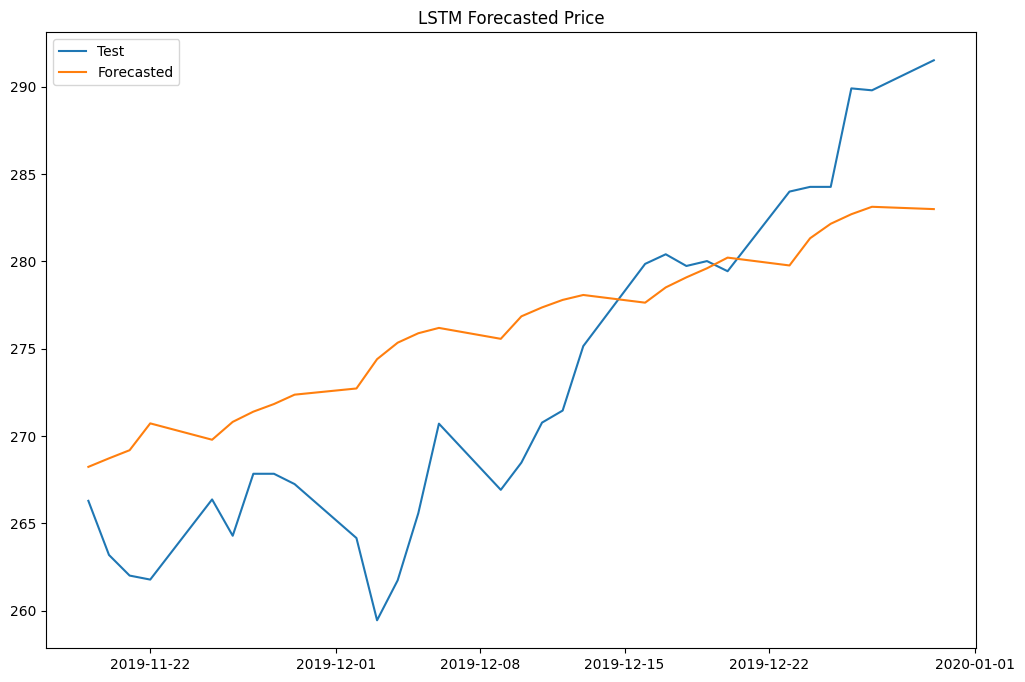

In [125]:
plt.figure(figsize = (12,8))
#plt.plot(price.index[:-h], price[:-h],  label = 'Train')
plt.plot(price.index[-h:], price[-h:],  label = 'Test')
plt.plot(gru_forecast.index, gru_forecast, label = 'Forecasted')
plt.title('LSTM Forecasted Price')
plt.legend()
plt.show()